# Taxonomy Plots
These plots were made from a run that included the data from the PeerJ study, and also the adult samples from the Duguma 2017a reference, _Effects of Organic Amendments on Microbiota Associated with the Culex nigripalpus Mosquito Vector of the Saint Louis Encephalitis and West Nile Viruses_.

In [1]:
library(ggplot2)
library(cowplot)
library(reshape2)
library(hues)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
asv_tab_full <- read.table("data/asv_table_all_2018.tab", comment.char="", header=1, skip=1, sep="\t", row.names=1)
taxonomy <- read.table("data/taxonomy_all_2018.tsv", sep="\t", header=1, row.names=1)
md <- read.table("data/METADATA_all.txt", sep="\t", header=1, row.names=1, comment.char="")
asv_tab <- scale(asv_tab_full, center=FALSE, scale=colSums(asv_tab_full))
asv_tab <- merge(taxonomy, asv_tab, by=0)
asv_tab <- melt(asv_tab[,! colnames(asv_tab) %in% c("Confidence")]) # Exclude the confidence column
asv_tab$variable <- gsub("^X","", asv_tab$variable)

Using Row.names, Taxon as id variables


In [3]:
cut_taxonomy_string <- function(x, n) {
    sp <- unlist(strsplit(x,";"))
    if (length(sp) >= n) {
        if (n>=5) {
            return(paste(sp[n-1],sp[n]))
        } else {
            return(paste(sp[n]))
        }
    } else {
        if (n>=5) {
            return(paste(sp[length(sp)-1], sp[length(sp)]))
        } else {
            return(paste(sp[length(sp)]))
        }
    }
}

get_melted_taxon_table <- function(n) {
    rel_abund_tab <- aggregate(asv_tab$value, by=list(asv_tab$variable, asv_tab$Taxon), FUN=sum)
    colnames(rel_abund_tab) <- c("SampleID", "Taxon", "RelAbund")
    rel_abund_tab$Classification <- unlist(lapply(as.character(rel_abund_tab$Taxon), function(x) cut_taxonomy_string(x, n)))
    rel_abund_tab
}

## Taxonomy Bar Plot

In [4]:
options(repr.plot.height=5, repr.plot.width=8)
taxonomy_barplot <- function(level) {
    genus_tab <- get_melted_taxon_table(level)
    mean_tab <- aggregate(genus_tab$RelAbund, by=list(genus_tab$SampleID, genus_tab$Classification), FUN=sum)
    if (level > 2) {
        abundant <- mean_tab[mean_tab$x >= 0.15,"Group.2"]
    } else {
        abundant <- genus_tab$Classification
    }
    genus_tab[! genus_tab$Classification %in% abundant, "Classification"] <- "Other"
    genus_tab$Location <- md[genus_tab$SampleID,"location"]
    genus_tab$Location <- as.factor(genus_tab$Location)
    levels(genus_tab$Location) <- c("Palmetto Inland", "Palmetto Coast", "Vero Beach", "Duguma et al. 2017a")
    genus_tab$SampleID <- as.factor(genus_tab$SampleID)
    levels(genus_tab$SampleID) <- c("1","2","3","4","5","6","7","8","9","10","11","12","13","14",
                                    "VB1","VB2","VB3","VB4",
                                    "PC1","PC2","PC3","PC4","PC5","PI1","PI2","PI3","PI4","PI5","PI6","PC6")
    set.seed(115)
    ggplot(genus_tab, aes(x=SampleID, y=RelAbund, fill=Classification)) + 
        geom_bar(stat='identity', colour='black', size=0.25) + theme(legend.position='bottom', legend.text=element_text(size=5), axis.text.x = element_text(size=8), axis.text.y = element_text(size=8)) +
        facet_grid(.~Location, scales = "free", space="free_x") + xlab("Sample") + ylab("Relative Abundance") +
        scale_fill_manual(guide=guide_legend(nrow = 7), values=as.vector(iwanthue(length(unique(genus_tab$Classification)), random = TRUE)))
   
}

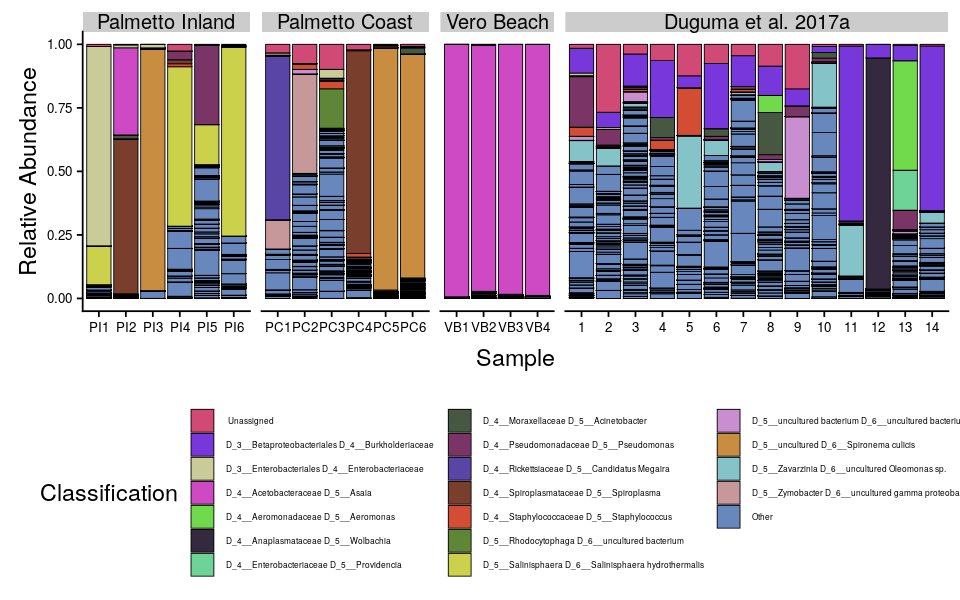

In [22]:
#pdf("Figure3.pdf", width=11, height=5)
taxonomy_barplot(7)
#dev.off()

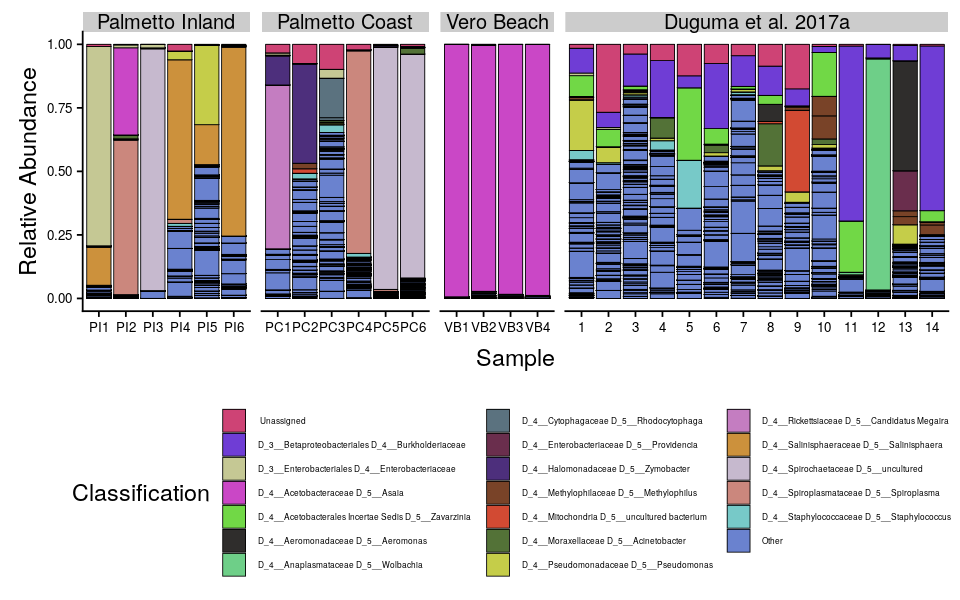

In [6]:
taxonomy_barplot(6)

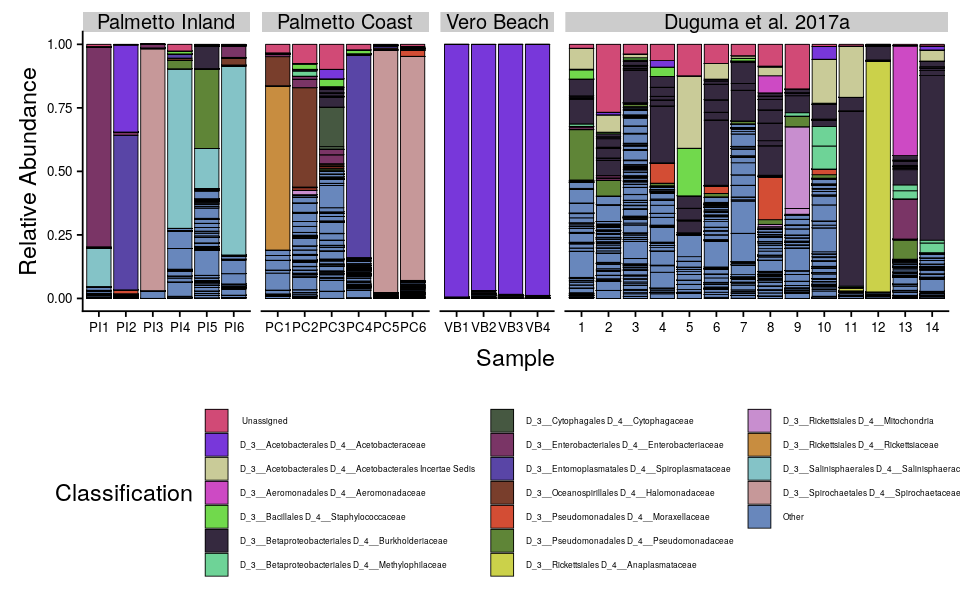

In [7]:
taxonomy_barplot(5)

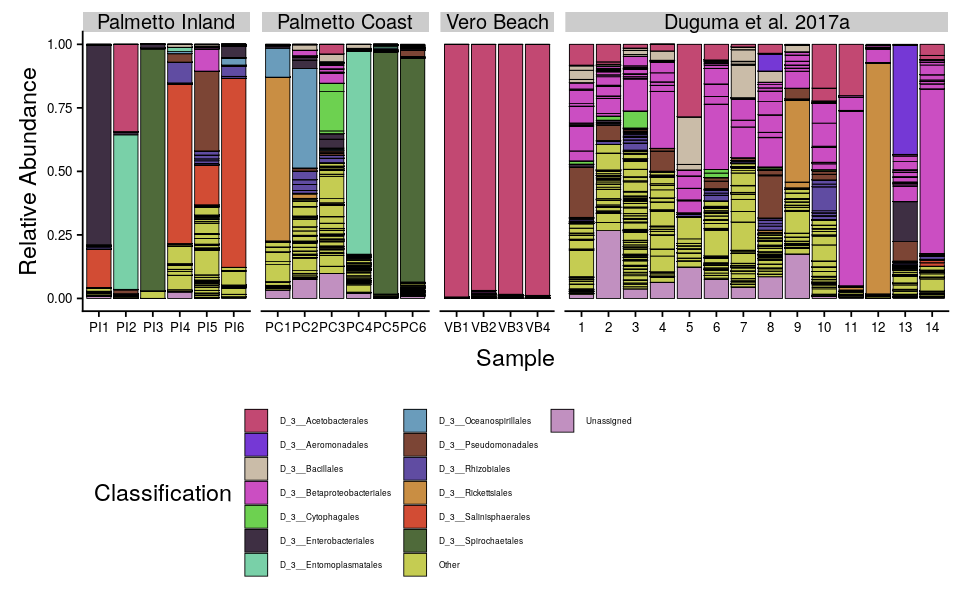

In [8]:
taxonomy_barplot(4)

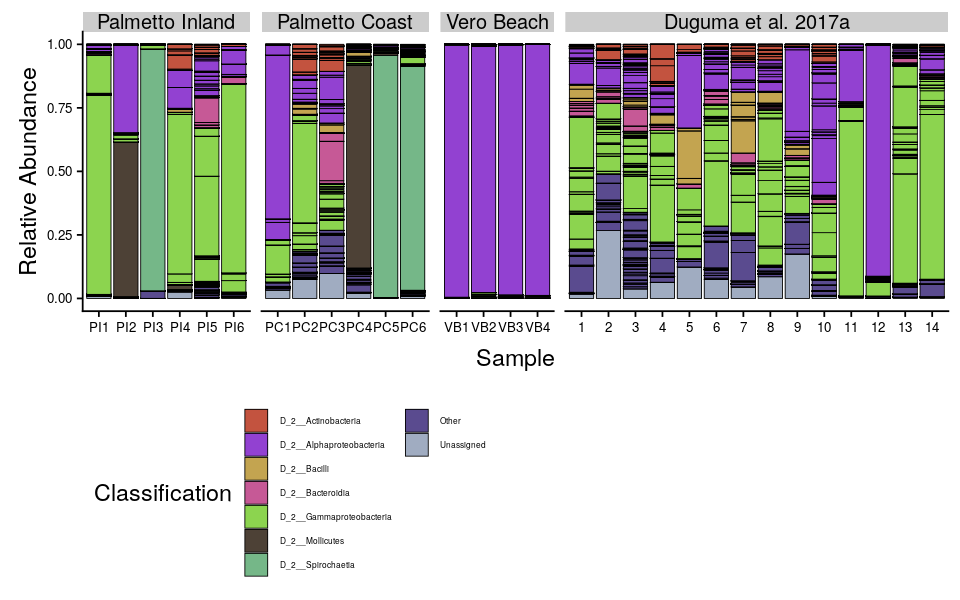

In [9]:
taxonomy_barplot(3)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1664000)”

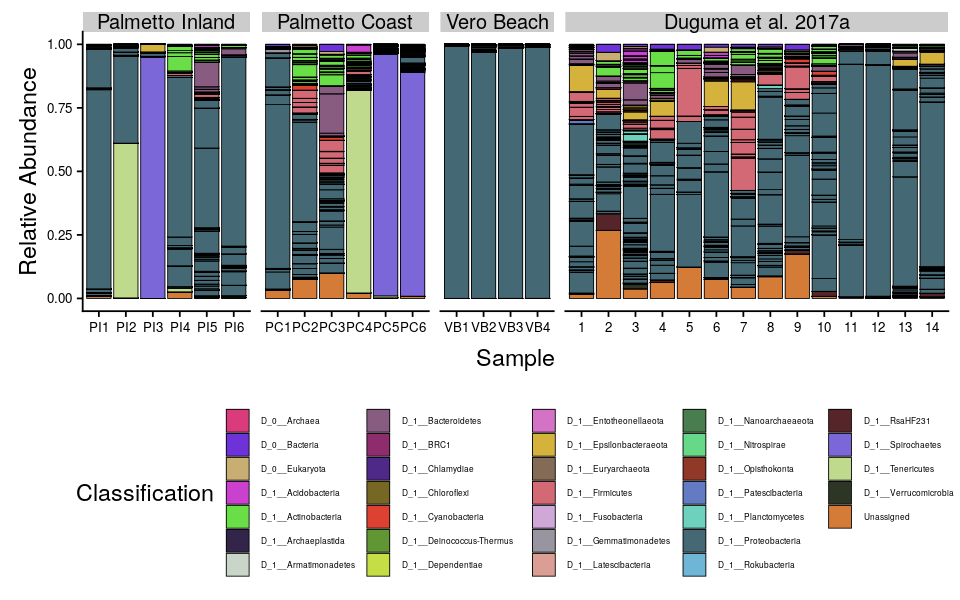

In [10]:
taxonomy_barplot(2)

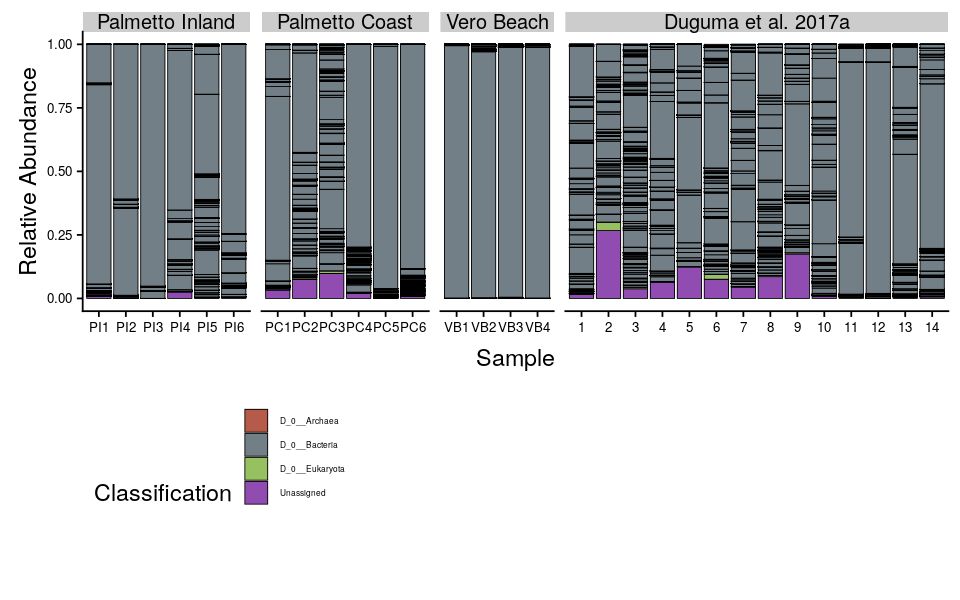

In [11]:
taxonomy_barplot(1)

In [12]:
print_taxon_table <- function(level) {
    taxon_tab <- get_melted_taxon_table(level)
    # Aggregate and normalize by location
    taxon_tab$Location <- md[taxon_tab$SampleID,'location']
    taxon_tab$Location <- as.factor(taxon_tab$Location)
    levels(taxon_tab$Location) <- c("Palmetto Inland", "Palmetto Coast", "Vero Beach", "Vero Beach II")
    taxon_tab <- aggregate(taxon_tab$RelAbund, by=list(taxon_tab$Location, taxon_tab$Classification), FUN=sum)
    colnames(taxon_tab) <- c("Location", "Classification", "RelAbund")
    taxon_tab[taxon_tab$Location == 'Vero Beach','RelAbund'] <- taxon_tab[taxon_tab$Location == 'Vero Beach','RelAbund']/4*100
    taxon_tab[taxon_tab$Location == 'Palmetto Inland','RelAbund'] <- taxon_tab[taxon_tab$Location == 'Palmetto Inland','RelAbund']/6*100
    taxon_tab[taxon_tab$Location == 'Palmetto Coast','RelAbund'] <- taxon_tab[taxon_tab$Location == 'Palmetto Coast','RelAbund']/6*100
    taxon_tab[taxon_tab$Location == 'Vero Beach II','RelAbund'] <- taxon_tab[taxon_tab$Location == 'Vero Beach II','RelAbund']/14*100
    # Round for pretty print
    taxon_tab$RelAbund <- round(taxon_tab$RelAbund, 2)
    # Re-cast as wide for viewing
    taxon_tab <- dcast(data = taxon_tab, formula = Classification~Location,fun.aggregate = sum,value.var = "RelAbund")
    # Order by largest row sums
    taxon_tab <- taxon_tab[order(rowSums(taxon_tab[,2:5]), decreasing=TRUE),]                                    
    taxon_tab
}

In [13]:
print_taxon_table(1)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach,Vero Beach II
2,D_0__Bacteria,99.27,95.65,99.99,92.82
4,Unassigned,0.70,3.98,0.01,6.54
3,D_0__Eukaryota,0.03,0.37,0.00,0.60
1,D_0__Archaea,0.00,0.00,0.00,0.04


In [14]:
print_taxon_table(2)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach,Vero Beach II
27,D_1__Proteobacteria,65.30,35.22,99.72,69.08
30,D_1__Spirochaetes,15.88,30.57,0.00,0.00
31,D_1__Tenericutes,10.40,13.42,0.00,0.00
18,D_1__Firmicutes,0.66,4.42,0.04,7.99
5,D_1__Actinobacteria,2.91,5.67,0.01,4.32
33,Unassigned,0.70,3.98,0.01,6.54
8,D_1__Bacteroidetes,2.74,3.55,0.00,3.40
16,D_1__Epsilonbacteraeota,0.51,0.02,0.03,3.79
2,D_0__Bacteria,0.14,0.73,0.00,0.99
4,D_1__Acidobacteria,0.20,0.63,0.00,0.63


In [15]:
print_taxon_table(3)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach,Vero Beach II
13,D_2__Alphaproteobacteria,13.41,19.04,98.64,24.43
32,D_2__Gammaproteobacteria,51.76,16.15,1.06,44.06
55,D_2__Spirochaetia,15.88,30.57,0.00,0.00
42,D_2__Mollicutes,10.40,13.42,0.00,0.00
67,Unassigned,0.70,3.98,0.01,6.54
12,D_2__Actinobacteria,2.62,4.33,0.01,4.06
17,D_2__Bacteroidia,2.74,3.55,0.00,3.40
16,D_2__Bacilli,0.36,1.70,0.02,5.22
24,D_2__Clostridia,0.08,1.85,0.02,2.54
20,D_2__Campylobacteria,0.51,0.02,0.03,3.79


In [16]:
print_taxon_table(4)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach,Vero Beach II
24,D_3__Acetobacterales,5.75,0.81,98.36,7.78
126,D_3__Spirochaetales,15.88,30.57,0.00,0.00
36,D_3__Betaproteobacteriales,1.78,2.20,0.49,31.43
119,D_3__Salinisphaerales,28.10,0.01,0.31,0.26
67,D_3__Entomoplasmatales,10.40,13.42,0.00,0.00
115,D_3__Rickettsiales,0.00,11.12,0.00,9.22
66,D_3__Enterobacteriales,14.33,2.00,0.13,1.41
108,D_3__Pseudomonadales,6.17,0.97,0.13,5.46
149,Unassigned,0.70,3.98,0.01,6.54
98,D_3__Oceanospirillales,0.65,8.74,0.00,0.03


In [17]:
print_taxon_table(5)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach,Vero Beach II
50,D_3__Acetobacterales D_4__Acetobacteraceae,5.75,0.81,98.36,0.76
241,D_3__Spirochaetales D_4__Spirochaetaceae,15.88,30.57,0.00,0.00
75,D_3__Betaproteobacteriales D_4__Burkholderiaceae,1.64,1.59,0.47,26.93
229,D_3__Salinisphaerales D_4__Salinisphaeraceae,28.10,0.01,0.00,0.00
136,D_3__Entomoplasmatales D_4__Spiroplasmataceae,10.40,13.42,0.00,0.00
135,D_3__Enterobacteriales D_4__Enterobacteriaceae,14.33,2.00,0.13,1.41
4,Unassigned,0.70,3.98,0.01,6.54
225,D_3__Rickettsiales D_4__Rickettsiaceae,0.00,10.74,0.00,0.00
193,D_3__Oceanospirillales D_4__Halomonadaceae,0.65,8.74,0.00,0.03
204,D_3__Pseudomonadales D_4__Pseudomonadaceae,5.81,0.19,0.12,3.26


In [18]:
print_taxon_table(6)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach,Vero Beach II
111,D_4__Acetobacteraceae D_5__Asaia,5.72,0.07,98.29,0.01
443,D_4__Spirochaetaceae D_5__uncultured,15.88,30.57,0.00,0.00
421,D_4__Salinisphaeraceae D_5__Salinisphaera,28.10,0.01,0.00,0.00
444,D_4__Spiroplasmataceae D_5__Spiroplasma,10.40,13.42,0.00,0.00
54,D_3__Betaproteobacteriales D_4__Burkholderiaceae,0.06,0.08,0.12,18.47
68,D_3__Enterobacteriales D_4__Enterobacteriaceae,13.51,0.75,0.00,0.13
4,Unassigned,0.70,3.98,0.01,6.54
408,D_4__Rickettsiaceae D_5__Candidatus Megaira,0.00,10.74,0.00,0.00
376,D_4__Pseudomonadaceae D_5__Pseudomonas,5.81,0.19,0.12,3.26
278,D_4__Halomonadaceae D_5__Zymobacter,0.03,8.52,0.00,0.03


In [19]:
print_taxon_table(7)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach,Vero Beach II
109,D_4__Acetobacteraceae D_5__Asaia,5.72,0.07,98.29,0.01
564,D_5__uncultured D_6__Spironema culicis,15.88,30.57,0.00,0.00
520,D_5__Salinisphaera D_6__Salinisphaera hydrothermalis,28.10,0.01,0.00,0.00
349,D_4__Spiroplasmataceae D_5__Spiroplasma,10.40,13.42,0.00,0.00
54,D_3__Betaproteobacteriales D_4__Burkholderiaceae,0.06,0.08,0.12,18.47
68,D_3__Enterobacteriales D_4__Enterobacteriaceae,13.51,0.75,0.00,0.13
4,Unassigned,0.70,3.98,0.01,6.54
325,D_4__Rickettsiaceae D_5__Candidatus Megaira,0.00,10.74,0.00,0.00
300,D_4__Pseudomonadaceae D_5__Pseudomonas,5.81,0.11,0.12,3.26
595,D_5__Zymobacter D_6__uncultured gamma proteobacterium,0.03,8.52,0.00,0.03


In [20]:
#Peeking at the ASV table to see the dominating taxa
sorted_asvs <- asv_tab_full[order(rowSums(asv_tab_full), decreasing = TRUE),]
sorted_asvs$Taxonomy <- taxonomy[rownames(sorted_asvs),"Taxon"]
asv_tab_melt <- asv_tab_full
asv_tab_melt$id <- rownames(asv_tab_melt)
asv_tab_melt <- melt(asv_tab_melt)
asv_tab_melt$variable <- gsub(pattern="X", replacement = "", x=asv_tab_melt$variable)
asv_tab_melt$location <- md$location[match(asv_tab_melt$variable, rownames(md))]
asv_tab_agg <- aggregate(asv_tab_melt$value, by=list(asv=asv_tab_melt$id, location=asv_tab_melt$location), FUN=sum)

asv_loc_tab <- dcast(asv_tab_agg, asv~location)
asv_loc_tab <- asv_loc_tab[order(rowSums(asv_loc_tab[,2:5]), decreasing=TRUE),]
asv_loc_tab$Taxon <- taxonomy[asv_loc_tab$asv,'Taxon']
taxonomy[asv_loc_tab[apply(asv_loc_tab[,2:5],1, min) > 0, "asv"], "Taxon"]
asv_loc_tab[apply(asv_loc_tab[,2:5],1, min) > 0, 2:5]
#Search for specific taxa
asv_loc_tab[grep("Thorsellia", asv_loc_tab$Taxon), ]
asv_loc_tab[grep("Asaia", asv_loc_tab$Taxon), ]
asv_loc_tab[grep("Wolbachia", asv_loc_tab$Taxon), ]
asv_loc_tab[grep("Burkholderiaceae", asv_loc_tab$Taxon), ]

Using id as id variables
Using x as value column: use value.var to override.


[1] D_0__Bacteria;D_1__Spirochaetes;D_2__Spirochaetia;D_3__Spirochaetales;D_4__Spirochaetaceae;D_5__uncultured;D_6__Spironema culicis                    
[2] D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia                                     
[3] D_0__Bacteria;D_1__RsaHF231                                                                                                                          
[4] D_0__Bacteria;D_1__Epsilonbacteraeota;D_2__Campylobacteria;D_3__Campylobacterales;D_4__Arcobacteraceae;D_5__Arcobacter                               
[5] D_0__Bacteria;D_1__Firmicutes;D_2__Erysipelotrichia;D_3__Erysipelotrichales;D_4__Erysipelotrichaceae;D_5__uncultured;D_6__uncultured bacterium       
[6] D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Enterobacteriales;D_4__Enterobacteriaceae;D_5__Thorsellia;D_6__Thorsellia kenyensis  
[7] D_0__Bacteria;D_1__Cyanobacteria;D_2__Oxyphotobacteria;D_3__Chloroplast                                                                              
[8] D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Rubritepida;D_6__uncultured bacterium     
[9] D_0__Bacteria;D_1__Cyanobacteria;D_2__Oxyphotobacteria;D_3__Chloroplast;D_4__Tetradesmus obliquus;D_5__Tetradesmus obliquus;D_6__Tetradesmus obliquus
643 Levels: D_0__Archaea ...

,B1GF (-82.49683333 27.62796667),"B1P (-82.5526666666666, 27.64048333)",Vero Beach,Vero Beach Mesocosm
2421,73935,215482,7,13
1547,8,38,217540,57
465,150,101,23,7388
1589,26,63,66,7426
466,168,176,17,576
492,67,94,13,622
464,46,13,465,42
1399,36,156,149,153
977,38,182,73,103


,asv,B1GF (-82.49683333 27.62796667),"B1P (-82.5526666666666, 27.64048333)",Vero Beach,Vero Beach Mesocosm,Taxon
492,2ad68734df74c667c7e7ca367176cbe4,67,94,13,622,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Enterobacteriales;D_4__Enterobacteriaceae;D_5__Thorsellia;D_6__Thorsellia kenyensis
1529,7e9fdcea3e2611bbeaf0eabd1f1b8302,89,412,0,181,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Enterobacteriales;D_4__Enterobacteriaceae;D_5__Thorsellia
2937,f57b86f1e01de4768aa86743224b6f9d,0,74,0,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Enterobacteriales;D_4__Enterobacteriaceae;D_5__Thorsellia;D_6__Coetzeea brasiliensis
1946,a324937440c77b348596501a2def3050,8,0,0,11,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Enterobacteriales;D_4__Enterobacteriaceae;D_5__Thorsellia


,asv,B1GF (-82.49683333 27.62796667),"B1P (-82.5526666666666, 27.64048333)",Vero Beach,Vero Beach Mesocosm,Taxon
1547,8066a946c2bce93a8f4d4dae660448fa,8,38,217540,57,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia
3036,fef790186b76b2c4a3f6a44d0e19e0d1,33310,276,100602,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia
1384,7222dc2c750fcddf48ed84678ca13e70,0,142,3545,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia
622,366dbe074e0968a6f33a896e1fa954fe,0,0,13,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia
1937,a22d73438c1a54f341c4b8337b3a9df1,0,0,11,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia
547,2f494256a0ce3d8570d3dc65ce4a8ca6,0,0,3,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia
1899,9ef7413e2a4bcd23b5cef417163d1b62,0,0,3,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia
257,162815797389f18a84fc4ec14fd1f00f,0,0,2,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia


,asv,B1GF (-82.49683333 27.62796667),"B1P (-82.5526666666666, 27.64048333)",Vero Beach,Vero Beach Mesocosm,Taxon
1778,935fecc29361bc1b49593af19511d667,17,60,0,105615,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Rickettsiales;D_4__Anaplasmataceae;D_5__Wolbachia
2295,be107b2301eb907767f0a94631ae9333,0,0,0,517,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Rickettsiales;D_4__Anaplasmataceae;D_5__Wolbachia
2464,cc333c3e5145f0d19c5995e126b08355,0,0,0,359,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Rickettsiales;D_4__Anaplasmataceae;D_5__Wolbachia
50,04f4b80628db643a2033ac50e28bb1b3,0,0,0,328,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Rickettsiales;D_4__Anaplasmataceae;D_5__Wolbachia
2068,ac6e984a16f82fa197c47c0f05eae0f6,0,0,0,323,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Rickettsiales;D_4__Anaplasmataceae;D_5__Wolbachia
2213,b7bf214a645c310a3e56f964e92d19b0,0,0,0,267,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Rickettsiales;D_4__Anaplasmataceae;D_5__Wolbachia
560,30b7b6572130cc7b43eeb09b8bbff09e,0,0,0,265,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Rickettsiales;D_4__Anaplasmataceae;D_5__Wolbachia
780,42e6b67c49c939c81ffa87a50d2f21be,0,0,0,263,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Rickettsiales;D_4__Anaplasmataceae;D_5__Wolbachia
64,06386174c34de1b672b56908aaba4738,0,0,0,248,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Rickettsiales;D_4__Anaplasmataceae;D_5__Wolbachia
434,25acff8138eda753c5ab1576c08c0d07,0,0,0,245,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Rickettsiales;D_4__Anaplasmataceae;D_5__Wolbachia


,asv,B1GF (-82.49683333 27.62796667),"B1P (-82.5526666666666, 27.64048333)",Vero Beach,Vero Beach Mesocosm,Taxon
2436,ca3f1833601676cff85e6e4ba1174a5e,58,0,35,174228,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Betaproteobacteriales;D_4__Burkholderiaceae
2683,df439cf5789bc44f615a9d6fb552c1ef,0,0,0,10962,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Betaproteobacteriales;D_4__Burkholderiaceae;D_5__Comamonas
888,4c7eafc202549b7b6b3d09acd3242522,8717,0,190,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Betaproteobacteriales;D_4__Burkholderiaceae;D_5__Delftia
719,3e828495b70b24e492e4716e403e4cd0,0,0,0,8216,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Betaproteobacteriales;D_4__Burkholderiaceae;D_5__Hydrogenophaga
1556,817bbcf7c01ed82c0728bd429452515d,0,0,0,6093,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Betaproteobacteriales;D_4__Burkholderiaceae;D_5__Ralstonia
2190,b618763065d9a1fb1cac97b2779ef40d,0,0,0,6054,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Betaproteobacteriales;D_4__Burkholderiaceae;D_5__Ideonella
885,4c460a08bdb30fc961cc1a4f353414e9,0,0,0,5905,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Betaproteobacteriales;D_4__Burkholderiaceae;D_5__Rhizobacter
1001,55aaf0d8560a063f8d73382be7879c8a,0,0,0,5558,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Betaproteobacteriales;D_4__Burkholderiaceae;D_5__Sphaerotilus
3041,ff3c01fefe4053c6a91312b61972125f,0,4716,0,0,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Betaproteobacteriales;D_4__Burkholderiaceae;D_5__Burkholderia-Caballeronia-Paraburkholderia
1509,7cdfc03d51bd22956b2f667a08ca0216,0,0,0,3670,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Betaproteobacteriales;D_4__Burkholderiaceae;D_5__Limnobacter


In [21]:
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 17.04

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.7.0
LAPACK: /usr/lib/lapack/liblapack.so.3.7.0

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] hues_0.1       reshape2_1.4.3 cowplot_0.9.3  ggplot2_3.0.0 

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.18         compiler_3.4.3       pillar_1.3.0        
 [4] plyr_1.8.4           bindr_0.1.1          base64enc_0.1-3     
 [7] tools_3.4.3          digest_0.6.15        uuid_0.1-2      